In [46]:
import math
import copy
import random
import numpy as np
import pandas as pd
from dataclasses import dataclass

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [47]:
CSV_PATH   = "../../data/CLEAN_BIGGEST_CHUNK-weather-PM2.5-data/weather-PM2.5-05T.csv"  # <- แก้ path ได้
DATE_COL   = "Date"
TARGET_COL = "PM2.5"

# Feature engineering
LAGS = [1, 2, 3, 7, 14]
ROLL_WINDOWS = [3, 7, 14]

# Split ratios (time series)
TRAIN_RATIO = 0.7
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

# Windowing for GRU
SEQ_LEN  = 14     # ใช้ย้อนหลัง 14 วัน
HORIZON  = 1      # ทำนาย 1 วันถัดไป
STRIDE   = 1

# Training
SEED = 42
BATCH_SIZE = 64
EPOCHS = 100
LR = 1e-3
WEIGHT_DECAY = 1e-4
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [48]:
def load_and_clean(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df.columns = [c.strip() for c in df.columns]

    # Parse date (ของคุณเป็น m/d/YYYY ในตัวอย่าง)
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], format="%m/%d/%Y", errors="coerce")

    # Convert numeric cols
    for c in df.columns:
        if c != DATE_COL:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=[DATE_COL])
    df = df.sort_values(DATE_COL).drop_duplicates(subset=[DATE_COL]).reset_index(drop=True)
    return df


In [49]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["year"] = df[DATE_COL].dt.year
    df["month"] = df[DATE_COL].dt.month
    df["dayofweek"] = df[DATE_COL].dt.dayofweek
    df["dayofyear"] = df[DATE_COL].dt.dayofyear
    return df


def add_lag_and_rolling(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    df = df.copy()

    # lag features (past only)
    for lag in LAGS:
        df[f"{target_col}_lag{lag}"] = df[target_col].shift(lag)

    # rolling features (past only) -> shift(1) before rolling
    for w in ROLL_WINDOWS:
        s = df[target_col].shift(1)
        df[f"{target_col}_rollmean{w}"] = s.rolling(window=w, min_periods=1).mean()
        df[f"{target_col}_rollstd{w}"]  = s.rolling(window=w, min_periods=2).std()

    return df


In [50]:
def add_wind_dir_sincos_deg(
    df: pd.DataFrame,
    wind_dir_col: str,
    drop_original: bool = True
) -> pd.DataFrame:
    df = df.copy()

    # แปลงเป็นตัวเลขก่อน (เผื่อมี string)
    wd = pd.to_numeric(df[wind_dir_col], errors="coerce")

    # ทำให้อยู่ในช่วง 0..360 (กันค่าหลุด เช่น -10, 370)
    wd = wd % 360

    rad = np.deg2rad(wd)  # degrees -> radians

    df[f"{wind_dir_col}_sin"] = np.sin(rad)
    df[f"{wind_dir_col}_cos"] = np.cos(rad)

    if drop_original and wind_dir_col in df.columns:
        df = df.drop(columns=[wind_dir_col])

    return df


def add_time_features(
    df: pd.DataFrame,
    drop_original: bool = True
) -> pd.DataFrame:
    df = df.copy()

    df["year"] = df[DATE_COL].dt.year

    # month: 1..12 -> 0..11
    m = df[DATE_COL].dt.month - 1
    df["month_sin"] = np.sin(2*np.pi*m/12)
    df["month_cos"] = np.cos(2*np.pi*m/12)

    # dayofweek: 0..6
    dow = df[DATE_COL].dt.dayofweek
    df["dayofweek_sin"] = np.sin(2*np.pi*dow/7)
    df["dayofweek_cos"] = np.cos(2*np.pi*dow/7)

    # dayofyear: 1..365/366 -> ใช้จำนวนวันจริงของปีนั้น
    doy0 = df[DATE_COL].dt.dayofyear - 1
    days_in_year = df[DATE_COL].dt.is_leap_year.map({True: 366, False: 365}).astype(int)
    df["dayofyear_sin"] = np.sin(2*np.pi*doy0/days_in_year)
    df["dayofyear_cos"] = np.cos(2*np.pi*doy0/days_in_year)

    # ถ้าคุณเคยสร้าง month/dayofweek/dayofyear ไว้แล้วในขั้นก่อนหน้า -> ลบทิ้ง
    if drop_original:
        cols_to_drop = [c for c in ["month", "dayofweek", "dayofyear"] if c in df.columns]
        if cols_to_drop:
            df = df.drop(columns=cols_to_drop)

    return df


In [52]:
df = load_and_clean(CSV_PATH)
df = add_time_features(df, drop_original=True)
df = add_lag_and_rolling(df, target_col=TARGET_COL)
df = add_wind_dir_sincos_deg(df, wind_dir_col="Wind Dir", drop_original=True)

In [53]:
@dataclass
class SplitResult:
    train: pd.DataFrame
    val: pd.DataFrame
    test: pd.DataFrame


def time_series_split(df: pd.DataFrame, train_ratio=0.7, val_ratio=0.15) -> SplitResult:
    n = len(df)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train = df.iloc[:n_train].copy()
    val   = df.iloc[n_train:n_train + n_val].copy()
    test  = df.iloc[n_train + n_val:].copy()

    return SplitResult(train=train, val=val, test=test)


In [54]:
@dataclass
class PrepResult:
    train_df: pd.DataFrame
    val_df: pd.DataFrame
    test_df: pd.DataFrame
    feature_cols: list
    scaler: StandardScaler


def fill_missing_within_split(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    s = df.copy()
    s[cols] = s[cols].ffill()
    return s


def prepare_splits_for_model(train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame,
                            target_col: str) -> PrepResult:
    # feature cols: remove Date & target
    feature_cols = [c for c in train.columns if c not in [DATE_COL, target_col]]

    # fill missing inside each split only
    all_cols = feature_cols + [target_col]
    train = fill_missing_within_split(train, all_cols)
    val   = fill_missing_within_split(val, all_cols)
    test  = fill_missing_within_split(test, all_cols)

    # drop remaining NaNs (usually early lags)
    train = train.dropna(subset=all_cols).reset_index(drop=True)
    val   = val.dropna(subset=all_cols).reset_index(drop=True)
    test  = test.dropna(subset=all_cols).reset_index(drop=True)

    # scale: fit on train only
    scaler = StandardScaler()
    train_scaled = train.copy()
    val_scaled   = val.copy()
    test_scaled  = test.copy()

    train_scaled[feature_cols] = scaler.fit_transform(train[feature_cols].to_numpy())
    val_scaled[feature_cols]   = scaler.transform(val[feature_cols].to_numpy())
    test_scaled[feature_cols]  = scaler.transform(test[feature_cols].to_numpy())

    return PrepResult(
        train_df=train_scaled,
        val_df=val_scaled,
        test_df=test_scaled,
        feature_cols=feature_cols,
        scaler=scaler
    )



In [55]:
def make_windows_next_day(df: pd.DataFrame, feature_cols: list, target_col: str,
                          seq_len: int, horizon: int = 1, stride: int = 1):
    """
    X uses past seq_len rows, y is target at (end + horizon - 1)
    For horizon=1: y index = end
    Returns:
      X: (samples, seq_len, n_features)
      y: (samples,)
    """
    X_list, y_list = [], []
    n = len(df)

    last_start = n - (seq_len + horizon) + 1
    for start in range(0, last_start, stride):
        end = start + seq_len
        y_idx = end + horizon - 1

        X_seq = df.iloc[start:end][feature_cols].to_numpy(dtype=np.float32)
        y_val = float(df.iloc[y_idx][target_col])

        X_list.append(X_seq)
        y_list.append(y_val)

    X = np.stack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.float32)
    return X, y


class WindowDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [56]:
class GRURegressor(nn.Module):
    def __init__(self, n_features: int, hidden_size: int, num_layers: int, dropout: float):
        super().__init__()
        self.gru = nn.GRU(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        out, _ = self.gru(x)          # (B,T,H)
        last = out[:, -1, :]          # (B,H)
        y = self.head(last).squeeze(-1)
        return y

In [57]:
@torch.no_grad()
def eval_loss(model, loader, criterion):
    model.eval()
    total = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        pred = model(xb)
        loss = criterion(pred, yb)
        total += loss.item() * xb.size(0)
        n += xb.size(0)
    return total / max(1, n)


@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    preds, trues = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        pred = model(xb).detach().cpu().numpy()
        yb = yb.detach().cpu().numpy()
        preds.append(pred)
        trues.append(yb)
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    return trues, preds


def train_model(model, train_loader, val_loader, epochs: int, lr: float, weight_decay: float):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    history = {
        "train_loss": [],
        "val_loss": []
    }

    best_state = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")

    for ep in range(1, epochs + 1):
        model.train()
        running = 0.0
        n = 0

        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optimizer.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

            running += loss.item() * xb.size(0)
            n += xb.size(0)

        train_loss = running / max(1, n)
        val_loss = eval_loss(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model.state_dict())

        print(f"Epoch {ep:02d} | train_MSE={train_loss:.6f} | val_MSE={val_loss:.6f}")

    model.load_state_dict(best_state)
    return model, history


def plot_losses(history):
    plt.figure()
    plt.plot(history["train_loss"], label="train_loss (MSE)")
    plt.plot(history["val_loss"], label="val_loss (MSE)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Val Loss")
    plt.legend()
    plt.show()


def evaluate_metrics(y_true, y_pred, name="TEST"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAE={mae:.4f} | RMSE={rmse:.4f} | R2={r2:.4f}")
    return mae, rmse, r2


def plot_test_scatter(y_true, y_pred):
    plt.figure()
    plt.scatter(y_true, y_pred, s=12)
    plt.xlabel("y_true (PM2.5)")
    plt.ylabel("y_pred (PM2.5)")
    plt.title("Test: y_true vs y_pred")
    plt.show()



DEVICE: cpu
26
Epoch 01 | train_MSE=624.387877 | val_MSE=788.479703
Epoch 02 | train_MSE=550.312298 | val_MSE=652.632978
Epoch 03 | train_MSE=377.458234 | val_MSE=390.232709
Epoch 04 | train_MSE=209.452734 | val_MSE=239.370740
Epoch 05 | train_MSE=154.469597 | val_MSE=197.391789
Epoch 06 | train_MSE=121.351495 | val_MSE=182.169817
Epoch 07 | train_MSE=106.248716 | val_MSE=159.271429
Epoch 08 | train_MSE=94.609924 | val_MSE=156.142992
Epoch 09 | train_MSE=86.398403 | val_MSE=169.240275
Epoch 10 | train_MSE=79.514836 | val_MSE=173.554239
Epoch 11 | train_MSE=72.650128 | val_MSE=171.548830
Epoch 12 | train_MSE=67.285864 | val_MSE=118.760310
Epoch 13 | train_MSE=59.991101 | val_MSE=114.501397
Epoch 14 | train_MSE=55.803950 | val_MSE=124.245744
Epoch 15 | train_MSE=49.934875 | val_MSE=123.751207
Epoch 16 | train_MSE=46.249831 | val_MSE=123.222252
Epoch 17 | train_MSE=46.639220 | val_MSE=124.687976
Epoch 18 | train_MSE=42.450601 | val_MSE=121.775771
Epoch 19 | train_MSE=40.289868 | val_MSE=1

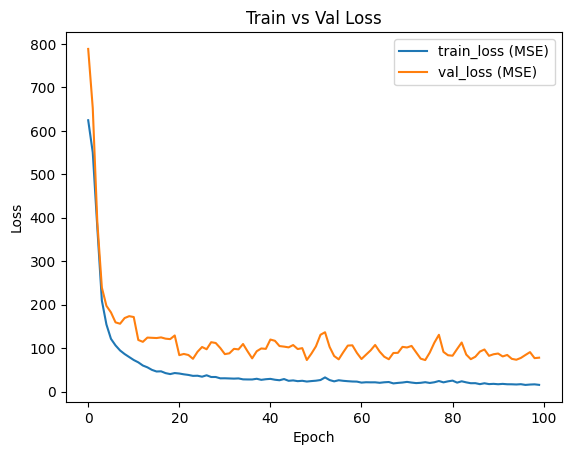

TEST: MAE=5.0368 | RMSE=7.5525 | R2=0.6015


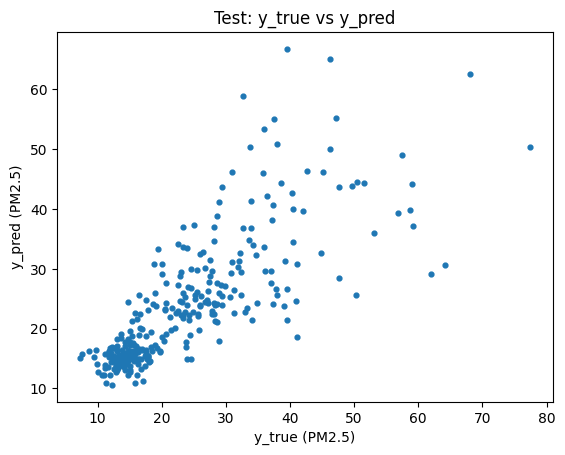


Next-day prediction:
Last date in data : 2024-09-27
Predicted date    : 2024-09-28
Predicted PM2.5   : 22.216


In [59]:
def main():
    set_seed(SEED)
    print("DEVICE:", DEVICE)

    # Load
    df = load_and_clean(CSV_PATH)
    df = add_time_features(df)
    df = add_lag_and_rolling(df, TARGET_COL)

    # Split
    splits = time_series_split(df, TRAIN_RATIO, VAL_RATIO)

    # Prep + scaling
    prep = prepare_splits_for_model(splits.train, splits.val, splits.test, TARGET_COL)

    # Windowing
    X_train, y_train = make_windows_next_day(prep.train_df, prep.feature_cols, TARGET_COL, SEQ_LEN, HORIZON, STRIDE)
    X_val,   y_val   = make_windows_next_day(prep.val_df,   prep.feature_cols, TARGET_COL, SEQ_LEN, HORIZON, STRIDE)
    X_test,  y_test  = make_windows_next_day(prep.test_df,  prep.feature_cols, TARGET_COL, SEQ_LEN, HORIZON, STRIDE)

    print(len(prep.feature_cols))

    # DataLoader
    train_loader = DataLoader(WindowDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False)
    val_loader   = DataLoader(WindowDataset(X_val, y_val),     batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(WindowDataset(X_test, y_test),   batch_size=BATCH_SIZE, shuffle=False)

    # Model
    n_features = X_train.shape[-1]
    model = GRURegressor(n_features, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)

    # Train
    model, history = train_model(model, train_loader, val_loader, EPOCHS, LR, WEIGHT_DECAY)

    # Plot train/val loss
    plot_losses(history)

    # Test evaluation
    y_true, y_pred = predict_all(model, test_loader)
    evaluate_metrics(y_true, y_pred, name="TEST")

    # Plot y_true vs y_pred (test)
    plot_test_scatter(y_true, y_pred)

    # (Optional) predict next day from latest window in full df
    df_feat = df.copy().dropna(subset=prep.feature_cols + [TARGET_COL]).reset_index(drop=True)
    df_feat_scaled = df_feat.copy()
    df_feat_scaled[prep.feature_cols] = prep.scaler.transform(df_feat[prep.feature_cols].to_numpy())

    last_seq = df_feat_scaled.iloc[-SEQ_LEN:][prep.feature_cols].to_numpy(dtype=np.float32)
    last_seq_t = torch.tensor(last_seq).unsqueeze(0).to(DEVICE)

    model.eval()
    with torch.no_grad():
        next_day_pred = model(last_seq_t).item()

    last_date = df_feat_scaled.iloc[-1][DATE_COL]
    next_date = last_date + pd.Timedelta(days=1)
    print("\nNext-day prediction:")
    print(f"Last date in data : {last_date.date()}")
    print(f"Predicted date    : {next_date.date()}")
    print(f"Predicted PM2.5   : {next_day_pred:.3f}")


if __name__ == "__main__":
    main()